<a href="https://colab.research.google.com/github/joaopauloev/SeriesTemporais/blob/main/Projeto_SeriesTemporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Projeto Final - João Paulo Epifani Veloso - jpgev@cesar.school

### Este projeto visa prever os preços do Bitcoin diariamente usando Long Short-Term Memory (LSTM) e outras redes neurais recorrentes. Aplicando dados históricos de preços do Bitcoin para prever preços futuros.

Bitcoin é a criptomoeda mais antiga e conhecida, lançada pela primeira vez como código aberto em 2009 pelo anônimo Satoshi Nakamoto. O Bitcoin serve como um meio descentralizado de troca digital, com transações verificadas e registradas em um livro-razão público distribuído (o blockchain) sem a necessidade de uma autoridade confiável de manutenção de registros ou de um intermediário central. Os blocos de transação contêm um hash criptográfico SHA-256 de blocos de transação anteriores e, portanto, são "encadeados", servindo como um registro imutável de todas as transações que já ocorreram. Tal como acontece com qualquer moeda/mercadoria no mercado, o comércio de bitcoin e os instrumentos financeiros logo seguiram a adoção pública do bitcoin e continuaram a crescer. Estão incluídos aqui dados históricos do mercado de bitcoin em intervalos de 1 minuto para bolsas selecionadas de bitcoin onde a negociação ocorre.

## Importação de Bibliotecas:

* Manipulação de dados: numpy, pandas.
* Deep Learning: keras.
* Visualização: matplotlib.

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Deep learning
from keras.models import Model
from keras.layers import (LSTM, Dense, Dropout, Input, GRU, BatchNormalization)
from keras.callbacks import  ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError


# Machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Visualization
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Limpeza de Dados

* Remoção de valores nulos e duplicados.

In [4]:
path = '/content/btcusd_1-min_data.csv'
df = pd.read_csv(path)

In [7]:
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [5]:
df.shape

(6768281, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6768281 entries, 0 to 6768280
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 309.8 MB


In [8]:
df.describe()

,Timestamp,Open,High,Low,Close,Volume
count,6.768280e+06,6.768281e+06,6.768281e+06,6.768281e+06,6.768281e+06,6.768281e+06
mean,1.528541e+09,1.494786e+04,1.495424e+04,1.494128e+04,1.494788e+04,5.445329e+00
std,1.173450e+08,2.047368e+04,2.048136e+04,2.046579e+04,2.047370e+04,2.289141e+01
min,1.325412e+09,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00
25%,1.426947e+09,4.146800e+02,4.148100e+02,4.145000e+02,4.146600e+02,1.842000e-02
50%,1.528482e+09,6.307750e+03,6.309970e+03,6.305470e+03,6.307820e+03,4.981180e-01
75%,1.630017e+09,2.348153e+04,2.349097e+04,2.347200e+04,2.348159e+04,3.162937e+00
max,1.739578e+09,1.089460e+05,1.090300e+05,1.087760e+05,1.089600e+05,5.853852e+03


In [9]:
df.isnull().sum()

,0
Timestamp,1
Open,0
High,0
Low,0
Close,0
Volume,0


In [10]:
df.dropna(inplace=True)

In [11]:
df.duplicated().sum()

0

In [12]:
df.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [16]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

df.set_index('Timestamp', inplace=True)

In [17]:
df.sample(10)

,Open,High,Low,Close,Volume
Timestamp,,,,,
2015-05-26 19:33:00,236.20,236.20,236.20,236.20,0.445600
2014-08-11 14:32:00,587.96,587.96,587.96,587.96,1.253967
2020-06-22 12:18:00,9411.10,9411.61,9411.10,9411.10,0.018927
2013-12-11 22:03:00,889.00,899.80,889.00,896.30,85.140040
2019-04-22 11:58:00,5280.64,5280.64,5280.64,5280.64,1.000000
2023-01-09 04:15:00,17032.00,17046.00,17032.00,17044.00,7.943960
2012-12-20 15:37:00,13.41,13.41,13.41,13.41,0.000000
2012-11-30 05:25:00,12.20,12.20,12.20,12.20,0.000000
2013-12-24 22:02:00,628.12,632.25,628.12,632.25,51.949433


# Visualização de dados

* Gráfico de preços de fechamento do Bitcoin ao longo do tempo.

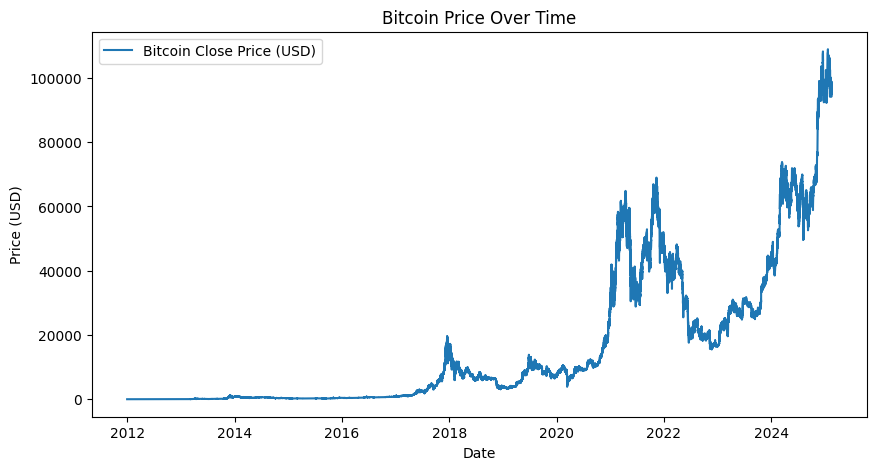

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Bitcoin Close Price (USD)')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

In [19]:
df.sample(10)

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-09-08 15:46:00,10.90,10.90,10.90,10.90,0.000000
2019-12-20 18:13:00,7170.21,7172.41,7165.26,7165.26,1.750271
2019-10-28 23:56:00,9408.84,9420.97,9408.83,9411.53,0.194654
2016-09-27 19:55:00,603.82,603.82,603.82,603.82,0.000000
2012-03-09 13:04:00,4.97,4.97,4.97,4.97,0.000000
2017-10-03 09:29:00,4346.06,4346.06,4346.05,4346.05,0.194304
2021-02-19 21:26:00,54300.00,54425.23,54256.57,54259.62,16.865050
2020-02-27 13:41:00,8839.97,8840.14,8822.55,8822.55,4.832564
2020-12-07 16:47:00,19205.69,19205.79,19200.42,19203.30,1.098951


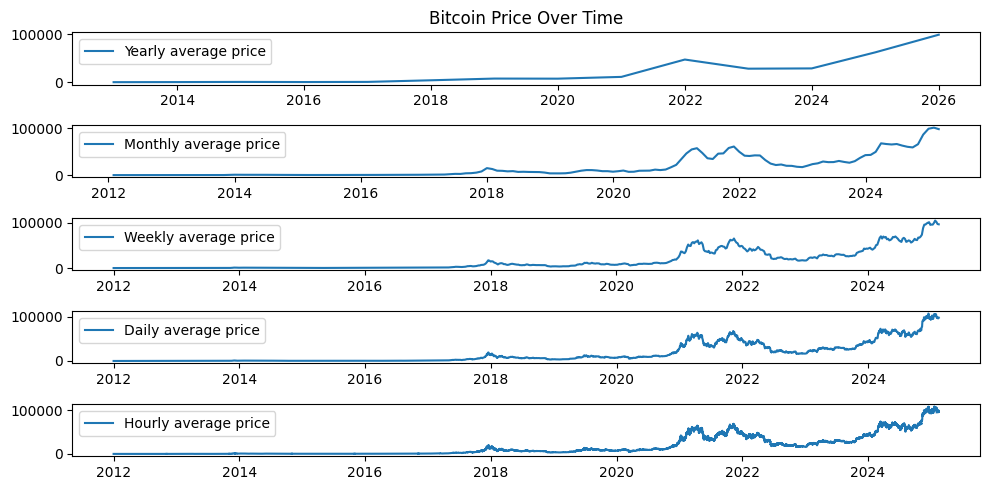

In [20]:
plt.figure(figsize=(10, 5), dpi=100)

plt.subplot(5, 1, 1)
plt.plot(df['Close'].resample('Y').mean(), label='Yearly average price')
plt.title('Bitcoin Price Over Time')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(df['Close'].resample('M').mean(), label='Monthly average price')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(df['Close'].resample('W').mean(), label='Weekly average price')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(df['Close'].resample('D').mean(), label='Daily average price')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(df['Close'].resample('H').mean(), label='Hourly average price')
plt.legend()

plt.tight_layout()

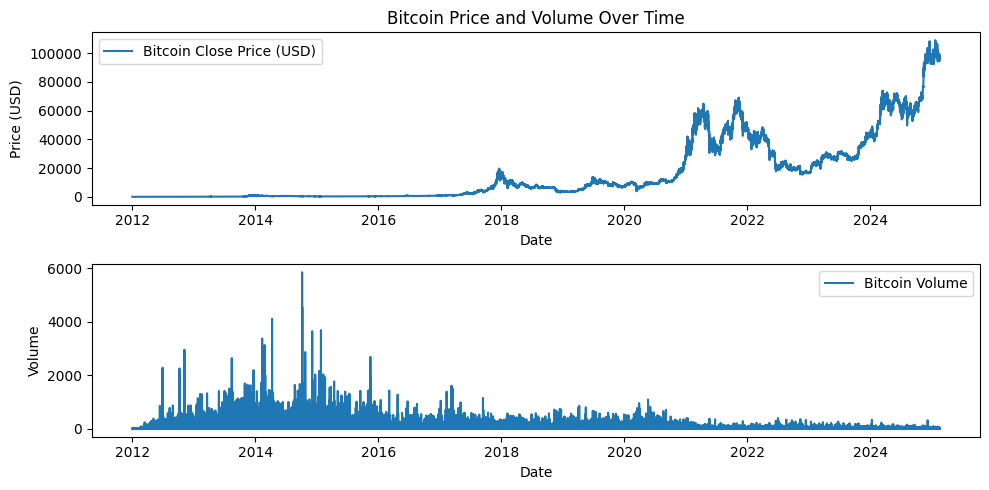

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(df['Close'], label='Bitcoin Close Price (USD)')
axs[0].set_title('Bitcoin Price and Volume Over Time')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price (USD)')
axs[0].legend()

axs[1].plot(df['Volume'], label='Bitcoin Volume')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Volume')
axs[1].legend()

plt.tight_layout()

# Engenharia de recursos

In [22]:
df = df.resample('1D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()
df

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01,4.58,4.84,4.58,4.84,10.000000
2012-01-02,4.84,5.00,4.84,5.00,10.100000
2012-01-03,5.00,5.32,5.00,5.29,107.085281
2012-01-04,5.29,5.57,4.93,5.57,107.233260
2012-01-05,5.57,6.46,5.57,6.42,70.328742
...,...,...,...,...,...
2025-02-11,97465.00,98474.00,94853.00,95754.00,1013.132147
2025-02-12,95756.00,98144.00,94091.00,97882.00,1318.472332
2025-02-13,97882.00,97882.00,95249.00,96627.00,694.056968


In [23]:
df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [24]:
df.dropna(inplace=True)

# Processamento de Dados

Usando dados diários de preços de Bitcoin (OHLCV - Open, High, Low, Close, Volume).
Atualmente focando no preço de fechamento apenas por simplicidade,
operando 50 dias de preços históricos para prever o preço de fechamento do dia seguinte.
Os dados são normalizados aplicando MinMaxScaler para melhorar o treinamento do modelo.

In [25]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [26]:
def create_sequences(data: pd.DataFrame, time_steps=60):
    X, y = [], []
    close_data = data['Close'].values
    for i in range(len(close_data) - time_steps):
        X.append(close_data[i:i+time_steps])
        y.append(close_data[i+time_steps])
    return np.array(X), np.array(y)

In [27]:
time_steps = 50  # os preços dos últimos 50 dias para prever o próximo preço
X, y = create_sequences(df, time_steps)

# Dividido em conjuntos de treinamento e teste (80% de treinamento, 20% de teste)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [28]:
# Imprimir formas de conjuntos de treinamento e teste
print(
    f"X Training set shape: {X_train.shape}",
    f"X Test set shape: {X_test.shape}",
    f"y Training set shape: {y_train.shape}",
    f"y Test set shape: {y_test.shape}",
    sep="\n"
)

X Training set shape: (3796, 50)
X Test set shape: (949, 50)
y Training set shape: (3796,)
y Test set shape: (949,)


In [29]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [30]:
X_train.shape

(3796, 50)

# Treinamento de modelo

### Testando com apenas 1 feature - Close

Estamos implementando um modelo de LSTM empilhado com a seguinte arquitetura:

* Camada de entrada: Shape (50 timesteps, 1 feature)
* Primeira camada LSTM: 128 unidades com normalização em lote (batch normalization) e dropout (0.2)
* Segunda camada LSTM: 128 unidades com normalização em lote (batch normalization) e dropout (0.2)
* Dense layer: 64 unidades com ativação ReLU
* Output layer: 1 unidade (previsão do preço do próximo dia)

Configuração do Treinamento:

* 80% dos dados para treinamento, 20% para teste
* Tamanho do lote (batch size): 64
* Epochs: 100
* Taxa de aprendizado (learning rate): 0.001 com ReduceLROnPlateau
* Parada antecipada (early stopping) e checkpointing do modelo implementados

In [31]:
inputs = Input(shape=(time_steps, 1))

# First LSTM layer
x = LSTM(units=128, return_sequences=True)(inputs)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Second LSTM layer
x = LSTM(units=128, return_sequences=False)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Dense layers
x = Dense(64, activation='relu')(x)
x = Dense(1)(x)

# Define model
model_lstm_l2_v1 = Model(inputs=inputs, outputs=x)
model_lstm_l2_v1.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[RootMeanSquaredError(),])

# Print model summary
model_lstm_l2_v1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207,489 (810.50 KB)

 Trainable params: 206,977 (808.50 KB)

 Non-trainable params: 512 (2.00 KB)

# Modelo de Treinamento - LSTM com 2 camadas

In [32]:
# Treinando o modelo
history = model_lstm_l2_v1.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=0
        ),
        ModelCheckpoint(
            '/kaggle/working/lstm_l2_v1.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        ),
    ],
    verbose=0
)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


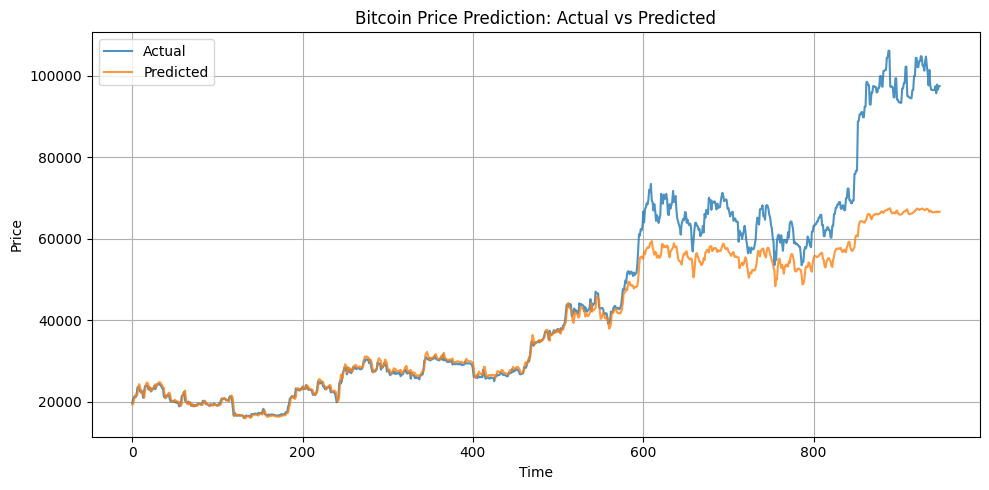

In [33]:
y_pred = model_lstm_l2_v1.predict(X_test)

plt.figure(figsize=(10, 5))

# Plot actual vs predicted values
plt.plot(y_test, label='Actual', alpha=0.8)
plt.plot(y_pred, label='Predicted', alpha=0.8)

plt.title('Bitcoin Price Prediction: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Aumentando o dropout rate para reduzir o overfit

In [34]:
inputs = Input(shape=(time_steps, 1))

# First LSTM layer
x = LSTM(units=128, return_sequences=True)(inputs)
x = BatchNormalization()(x)
x = Dropout(0.7)(x)

# Second LSTM layer
x = LSTM(units=128, return_sequences=False)(x)
x = BatchNormalization()(x)
x = Dropout(0.7)(x)

# Dense layers
x = Dense(64, activation='relu')(x)
x = Dense(1)(x)

# Define model
model_lstm_l2_v2 = Model(inputs=inputs, outputs=x)
model_lstm_l2_v2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[RootMeanSquaredError(),])

# Print model summary
model_lstm_l2_v2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 50, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207,489 (810.50 KB)

 Trainable params: 206,977 (808.50 KB)

 Non-trainable params: 512 (2.00 KB)

In [35]:
# Treinando o modelo
history = model_lstm_l2_v2.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            '/kaggle/working/model_lstm_l2_v2.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        ),
    ],
    verbose=0
)


Epoch 42: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 47: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step


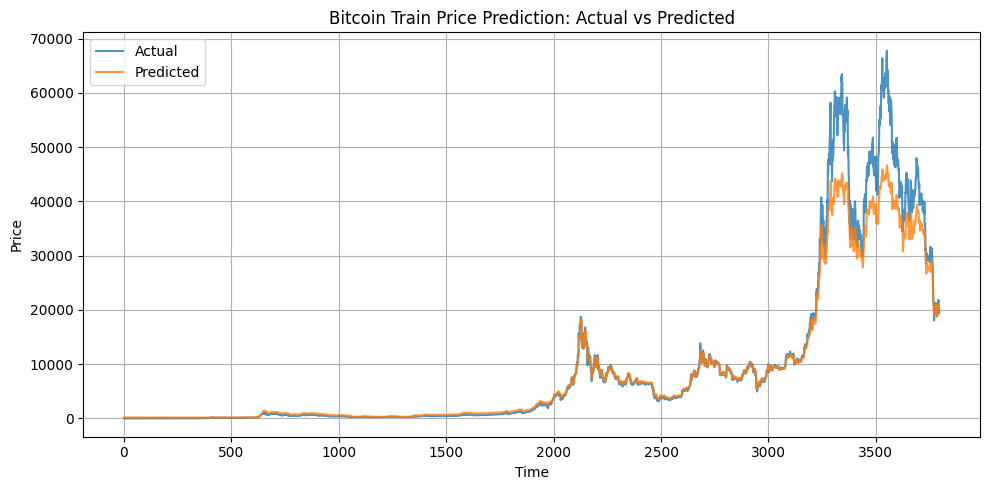

In [36]:
y_pred = model_lstm_l2_v2.predict(X_train)

plt.figure(figsize=(10, 5))

# Valores Reais vs Valores Previstos
plt.plot(y_train, label='Actual', alpha=0.8)
plt.plot(y_pred, label='Predicted', alpha=0.8)

plt.title('Bitcoin Train Price Prediction: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


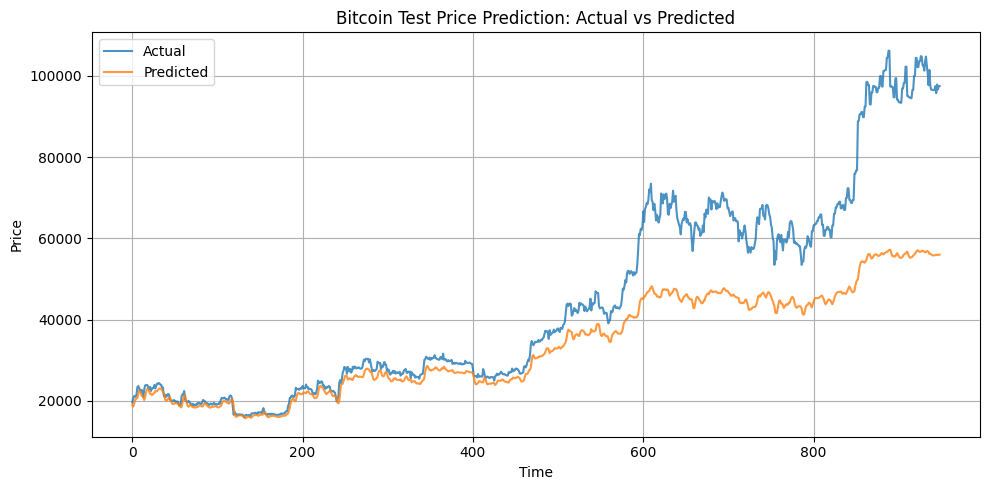

In [37]:
y_pred = model_lstm_l2_v2.predict(X_test)

plt.figure(figsize=(10, 5))

plt.plot(y_test, label='Actual', alpha=0.8)
plt.plot(y_pred, label='Predicted', alpha=0.8)

plt.title('Bitcoin Test Price Prediction: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [38]:
y_pred = model_lstm_l2_v2.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: ", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: ", mae)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Mean Absolute Percentage Error: ", mape, "%")

r2 = r2_score(y_test, y_pred)
print("R-Squared: ", r2)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Root Mean Squared Error:  17003.826774828576
Mean Absolute Error:  11011.580508841544
Mean Absolute Percentage Error:  52.419696835996355 %
R-Squared:  0.5383381923348055


### Alcançamos bons resultados com apenas 2 camadas LSTM. Geralmente, os modelos tendem a ajustar-se excessivamente ao prever os preços das ações, uma vez que os movimentos dos preços raramente seguem padrões históricos. Dado este desafio, nosso modelo demonstrou boa capacidade de generalização.

Treinando o modelo com o melhor parâmetro que obtivemos usando RandomSearchCV

RMSE: 5075.227327015663


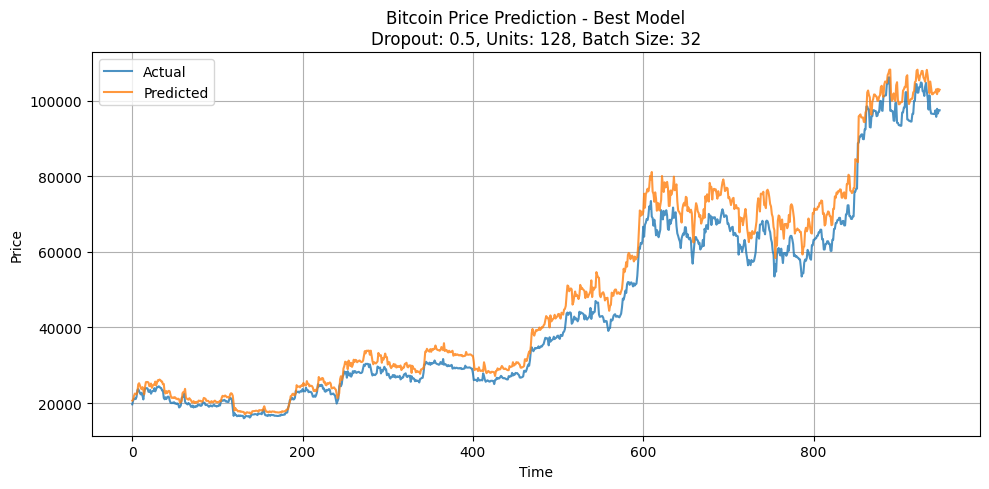

In [39]:
inputs = Input(shape=(time_steps, 1))

x = LSTM(units=64, return_sequences=True)(inputs)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = LSTM(units=64, return_sequences=False)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(64, activation='relu')(x)
x = Dense(1)(x)

model = Model(inputs=inputs, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.001),
             loss='mean_squared_error',
             metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train,
                   epochs=100,
                   batch_size=32,
                   validation_split=0.2,
                   verbose=0)

y_pred = model.predict(X_test, verbose=0)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual', alpha=0.8)
plt.plot(y_pred, label='Predicted', alpha=0.8)
plt.title('Bitcoin Price Prediction - Best Model\nDropout: 0.5, Units: 128, Batch Size: 32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Aplicando com GRU, usando os melhores parâmetros que obtivemos por RandomSearchCV

In [40]:
inputs = Input(shape=(time_steps, 1))

# First GRU layer
x = GRU(units=64, return_sequences=True)(inputs)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Second GRU layer
x = GRU(units=64, return_sequences=False)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Dense layers
x = Dense(64, activation='relu')(x)
x = Dense(1)(x)

# Define model
model_gru_2_layers = Model(inputs=inputs, outputs=x)
model_gru_2_layers.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[RootMeanSquaredError(),])

# Print model summary
model_gru_2_layers.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 50, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 50, 64)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 50, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,561 (166.25 KB)

 Trainable params: 42,305 (165.25 KB)

 Non-trainable params: 256 (1.00 KB)

In [41]:
# Treinando o Modelo
history = model_gru_2_layers.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=0
        ),
        ModelCheckpoint(
            '/kaggle/working/gru_l2_v1.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        ),
    ],
    verbose=0
)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


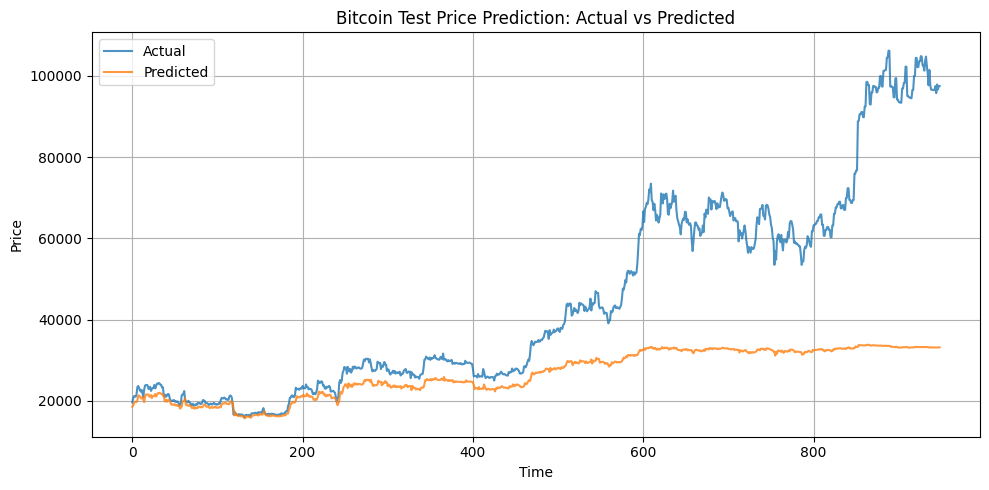

In [42]:
y_pred = model_gru_2_layers.predict(X_test)

plt.figure(figsize=(10, 5))

# Plot actual vs predicted values
plt.plot(y_test, label='Actual', alpha=0.8)
plt.plot(y_pred, label='Predicted', alpha=0.8)

plt.title('Bitcoin Test Price Prediction: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Conclusão

O projeto visa fornecer insights sobre a previsão de preços do Bitcoin, utilizando técnicas de machine learning.

## Análise do Desempenho do Modelo: LSTM vs GRU

* O modelo GRU não apresentou um desempenho ideal para esses dados de Séries Temporais.
* O LSTM parece ser mais adequado para este conjunto de dados devido à sua capacidade de capturar melhor dependências de longo prazo em dados de séries temporais financeiras.
* Provavelmente ocorre porque o portão de memória adicional do LSTM ajuda a reter padrões históricos de preços importantes de forma mais eficaz.